In [355]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from flask import Flask, jsonify
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.weightstats import ttest_ind

In [299]:
import numpy as np
import pandas as pd

In [300]:
import datetime as dt

In [197]:
# Python SQL Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,inspect

In [198]:
database_path = '/Users/edwardkohn/Desktop/UofM-COG-DATA-PT-09-2019-U-C-master 20/Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii.sqlite'
engine = create_engine(f"sqlite:///{database_path}")

In [199]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
#to explore database if needed
inspector = inspect(engine)

In [200]:
#  view all of the classes(tables) 
Base.classes.keys()

['measurement', 'station']

In [201]:
#see columns from measurement table
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [202]:
#see columns from station table
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [203]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [204]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [205]:
#see values from Measurement table
for row in session.query(Measurement.__table__).limit(2).all():
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)


In [206]:
#see values from Station table

for row in session.query(Station.__table__).all():
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


# Exploratory Climate Analysis

In [207]:
#last 12 months of precipitation data and plot the results

prcp_last_year = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

date_list = [combo[0] for combo in prcp_last_year]
pcrp_list = [combo[1] for combo in prcp_last_year]

pcrp_dict = {'dates':date_list,'precipitation':pcrp_list}
df = pd.DataFrame(pcrp_dict,index=date_list)
del df['dates']


In [208]:
df.index = pd.to_datetime(df.index)
df.index.sort_values(ascending=False)

DatetimeIndex(['2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23',
               '2017-08-22', '2017-08-22', '2017-08-22', '2017-08-21',
               '2017-08-21', '2017-08-21',
               ...
               '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-23',
               '2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23',
               '2016-08-23', '2016-08-23'],
              dtype='datetime64[ns]', length=2230, freq=None)

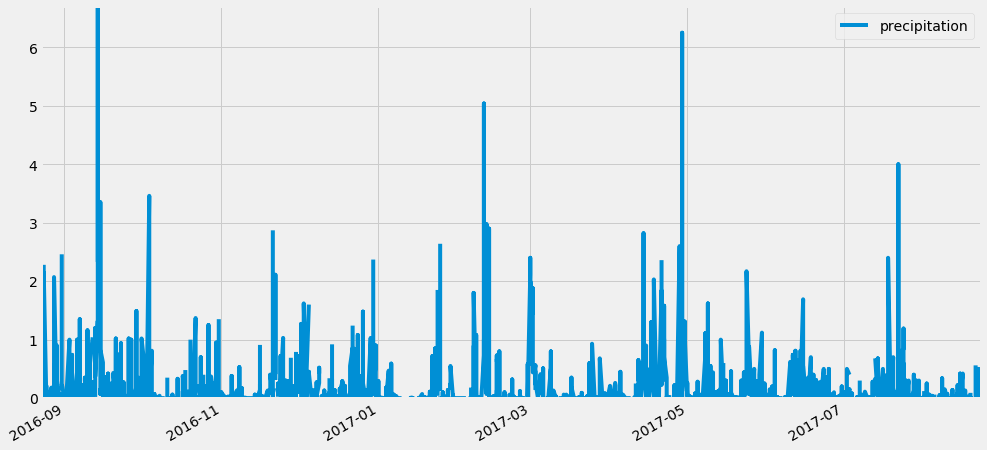

In [209]:
#plot
df.plot(figsize=(15,8)).autoscale(enable=True,tight=True)


In [210]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Total Number Of Stations

In [214]:
total_stations = session.query(Station.station).count()
print(total_stations)

9


# Highest Station Observations

In [215]:
station_obs = session.query(Station.station,Station.name, func.count(Measurement.station)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

print(station_obs)

name_list_hi = [combo[1] for combo in station_obs]
obs_list_hi = [combo[2] for combo in station_obs]
max_obs= max(obs_list_hi)
name_list_hi= name_list_hi[0]
print('-'*100)
print(f'Station {name_list_hi} has the hightes number of observations with {max_obs} counts')


[('USC00519281', 'WAIHEE 837.5, HI US', 2772), ('USC00519397', 'WAIKIKI 717.2, HI US', 2724), ('USC00513117', 'KANEOHE 838.1, HI US', 2709), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979), ('USC00517948', 'PEARL CITY, HI US', 1372), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]
----------------------------------------------------------------------------------------------------
Station WAIHEE 837.5, HI US has the hightes number of observations with 2772 counts


# Tobs temperature for past 12 month

In [216]:
highest_station_id = 'USC00519281'
tob_last_year = session.query(Measurement.date, Measurement.tobs,Measurement.station).\
filter(Measurement.station == highest_station_id).\
filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()


tob_date_list = [combo[0] for combo in tob_last_year]
tob_data_list = [combo[1] for combo in tob_last_year]



dict_for_tob = {'dates':tob_date_list,'tobs':tob_data_list}

df2=pd.DataFrame(dict_for_tob,index=tob_date_list)

del df2['dates']

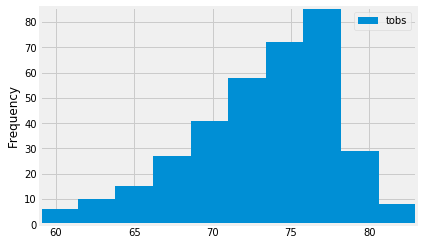

In [192]:
df2.plot.hist().autoscale(enable=True,tight=True)

# Trip Analysis

In [218]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


# Temperature Analysis I

In [360]:
df3_1= pd.read_csv('/Users/edwardkohn/Desktop/UofM-COG-DATA-PT-09-2019-U-C-master 20/Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii_measurements.csv')
df3_1['date'] = pd.to_datetime(df3_1['date'])
df3_final = df3_1[['date','tobs']]
df3_final['month'] = df3_final['date'].dt.month
june_dates=df3_final.loc[df3_final['month'] == 6,:]
december_dates=df3_final.loc[df3_final['month'] == 12,:]

june_avg = june_dates['tobs'].mean()
dec_avg = december_dates['tobs'].mean()


t_test=ttest_ind(june_dates['tobs'],december_dates['tobs'])
t_test

(31.60372399000329, 3.9025129038616655e-191, 3215.0)

# Temperature Analysis II

In [284]:
temp_during_trip_date = calc_temps('2017-04-01','2017-04-07')

rounded_avg =round(temp_during_trip_date[0][1],2)

print(f'Lowest temperature during trip is {temp_during_trip_date[0][0]} F')
print(f'Avg temperature during trip is {rounded_avg} F')
print(f'Highest temperature during trip is {temp_during_trip_date[0][2]} F')

Lowest temperature during trip is 67.0 F
Avg temperature during trip is 74.59 F
Highest temperature during trip is 80.0 F


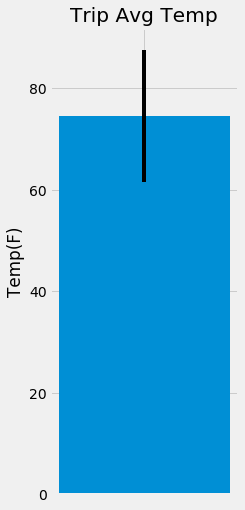

In [285]:
# "Trip Avg Temp" title
Title = 'Trip Avg Temp'
#average temperature for the y value
avg_temp = rounded_avg

# peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = temp_during_trip_date[0][2] - temp_during_trip_date[0][0]

fig,ax = plt.subplots(figsize=(3,8));
ax.bar(1,avg_temp,yerr=peak_to_peak,width = 0.2);
ax.set_title(Title)
ax.set_ylabel('Temp(F)')
ax.set_xticks([1])
ax.set_xticklabels([""]);

# Rainfall Avg per Weather Station

In [282]:
#avg rain in the past year for each station.
rain_year = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation, func.avg(Measurement.prcp)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).filter(Measurement.date.between('2016-04-01', '2017-04-01')).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()
rain_year

df3= pd.DataFrame(rain_year,columns=['station','name','Lat','Lon','elevetion','Avg_yearPrecipitation(1y)'])
df3.head()

,station,name,Lat,Lon,elevetion,Avg_yearPrecipitation(1y)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.541781
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.243169
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.162213
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121207
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.113926


# Daily Rainfall Average

In [287]:
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [316]:
# calculate the daily normals for your trip

list_of_dates = ['04-01','04-02','04-03','04-05','04-06','04-07']
list_with_years = ['2019-'+ date for date in list_of_dates]

# push each tuple of calculations into a list called `normals`

min_temp_1 = []
avg_temp_1 = []
max_temp_1 = []

for date in list_of_dates:
    min_avg_max=daily_normals(date)
    min_temp_1.append(min_avg_max[0][0])
    avg_temp_1.append(min_avg_max[0][1])
    max_temp_1.append(min_avg_max[0][2])

min_avg_max_dict = {'date':list_with_years,'tmin':min_temp_1,'tavg_temp':avg_temp_1,'tmax_temp':max_temp_1}

df4=pd.DataFrame(min_avg_max_dict)    

df4['date'] = pd.to_datetime(df4['date'])

df4=df4.set_index(df4['date'])
del df4['date']

In [317]:
df4.head()

,tmin,tavg_temp,tmax_temp
date,,,
2019-04-01,60.0,71.879310,80.0
2019-04-02,53.0,71.821429,79.0
2019-04-03,55.0,72.228070,78.0
2019-04-05,61.0,72.288136,80.0
2019-04-06,67.0,71.571429,77.0


[Text(0, 0.5, 'Temperature'), Text(0.5, 1.0, 'Daily Normal Temps(F)')]

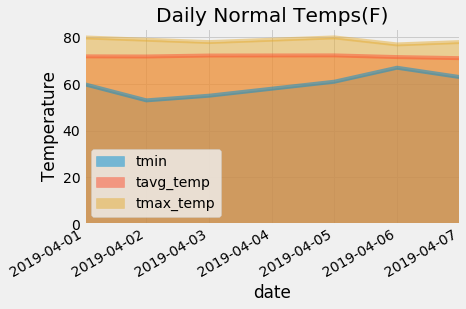

In [320]:
# Plot the daily normals as an area plot with `stacked=False`
ax=df4.plot.area(stacked=False,alpha=0.5)
ax.set(title='Daily Normal Temps(F)',ylabel='Temperature')
